In [4]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import cycle

def compare_model_predictions(
    ground_truth_npy: str,
    prediction_csvs: list,
    model_names: list,
    variable_name: str
):
    """
    Load a ground-truth time series (context + actual future) and multiple model
    prediction CSVs, then plot context, actual future, and each model’s predictions
    on a single line chart.

    Parameters
    ----------
    ground_truth_npy : str
        Path to a .npy file containing a 1D array of length (context_window + prediction_horizon).
        The first `context_window` entries are historical/context values, the remaining
        entries are the true future values.
    prediction_csvs : list of str
        Paths to CSV files, one per model. Each CSV must have two columns with header:
            "timestep", "<variable>"
        where "timestep" is an integer time index, and "<variable>" holds the predicted values.
    model_names : list of str
        Human-readable names for each model, in the same order as `prediction_csvs`.
    variable_name : str
        Name of the variable being plotted (e.g. "temp", "ozone"); used for axis labels
        and to infer the prediction column name in the CSVs.

    Raises
    ------
    ValueError
        If lengths of `prediction_csvs` and `model_names` differ,
        or if the timesteps in the CSVs don’t align exactly.
    """

    if len(prediction_csvs) != len(model_names):
        raise ValueError("`prediction_csvs` and `model_names` must have the same length.")

    # 1) Load the full series (context + actual future)
    full_series = np.load(ground_truth_npy, allow_pickle=True)
    total_length = full_series.shape[0]

    # 2) Load the first predictions file to get timesteps & horizon
    first_csv = prediction_csvs[0]
    timesteps = []
    preds0 = []
    with open(first_csv, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            timesteps.append(int(row["timestep"]))
            preds0.append(float(row[variable_name]))
    timesteps = np.array(timesteps)
    preds0 = np.array(preds0)

    # determine context window and prediction horizon
    prediction_horizon = len(timesteps)
    context_window = total_length - prediction_horizon

    # sanity check
    if context_window <= 0:
        raise ValueError(f"Context window computed as {context_window}; must be > 0.")

    # extract context & actual future from full_series
    context_series = full_series[:context_window]
    actual_future = full_series[context_window:]

    # 3) Load all model predictions, checking alignment
    all_preds = [preds0]
    for path in prediction_csvs[1:]:
        this_ts = []
        this_preds = []
        with open(path, newline="") as f:
            reader = csv.DictReader(f)
            for row in reader:
                this_ts.append(int(row["timestep"]))
                this_preds.append(float(row[variable_name]))
        this_ts = np.array(this_ts)
        this_preds = np.array(this_preds)

        # ensure timesteps match
        if not np.array_equal(this_ts, timesteps):
            raise ValueError(f"Timestep mismatch between {first_csv} and {path}.")
        all_preds.append(this_preds)

    # 4) Prepare plot styling cycles
    color_cycler = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    marker_cycler = cycle(['o', 's', '^', 'D', 'X', 'v', 'P', '*'])
    linestyle_cycler = cycle(['-', '--', '-.', ':'])

    # 5) Plot
    plt.figure(figsize=(12, 9))
    # a) plot context
    plt.plot(
        range(context_window),
        context_series,
        label="Context (history)",
        color='black',
        linestyle='-',
        marker='',
        linewidth=1.5
    )
    # b) plot actual future
    future_x = timesteps
    plt.plot(
        future_x,
        actual_future,
        label="Actual Future",
        color='grey',
        linestyle='-',
        marker='o'
    )
    # c) plot each model
    for model_name, preds in zip(model_names, all_preds):
        color = next(color_cycler)
        marker = next(marker_cycler)
        ls = next(linestyle_cycler)
        plt.plot(
            future_x,
            preds,
            label=model_name,
            color=color,
            linestyle=ls,
            marker=marker
        )

    plt.title(f"Forecast Comparison for '{variable_name}'")
    plt.xlabel("Time Step")
    plt.ylabel(variable_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


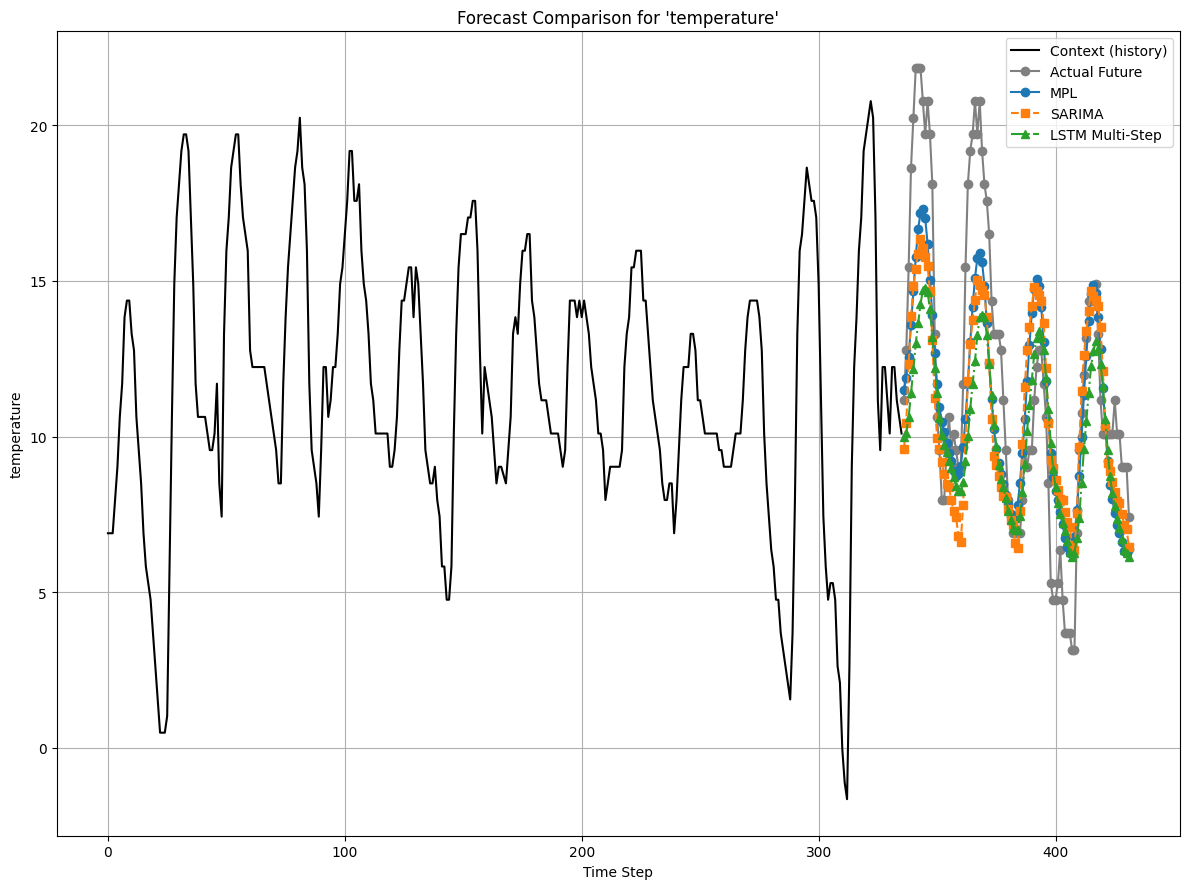

In [5]:
compare_model_predictions(
    ground_truth_npy="data/denw094_temp_full_series.npy",
    prediction_csvs=[
        "data/denw094_temp_predictions_mlp.csv",
        "data/denw094_temp_predictions_sarima.csv",
        "data/denw094_temp_predictions_lstm.csv"
    ],
    model_names=["MPL", "SARIMA", "LSTM Multi-Step"],
    variable_name="temperature"
)